In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Ahora las funciones utiles de sklearn para preprocesar datos y armar un pipeline
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as pp

#Y la estrella de este notebook:
from sklearn import svm

import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, balanced_accuracy_score,precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit


import seaborn as sns

import os
import tarfile

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/exord/UNSAM_IA/master/"
HOUSING_PATH = os.path.join(".", "datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    #urllib.request.urlretrieve(housing_url, tgz_path)
    !wget http://raw.githubusercontent.com/exord/UNSAM_IA/master/datasets/housing.tgz -P {housing_path}
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# SVM: Clasificación Iris dataset

## El Iris dataset

Exploremos uno de los datasets mas comunes, el Iris dataset

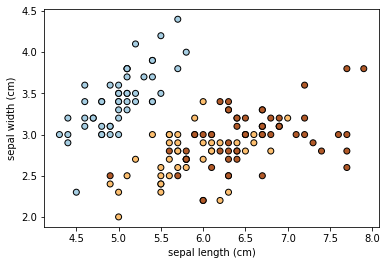

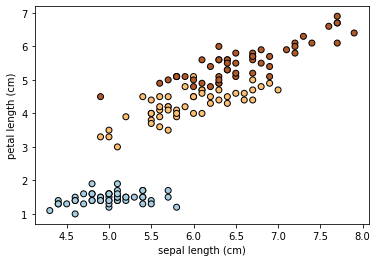

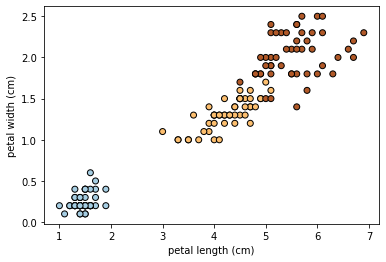

In [3]:
from sklearn import datasets
iris=datasets.load_iris()
X = iris.data
Y = iris.target

# Plot also the training points
for pair in ([0, 1], [0, 2], [2, 3]):
  plt.scatter(X[:, pair[0]], X[:, pair[1]], c=Y, edgecolors='k', cmap=plt.cm.Paired)
  plt.xlabel(iris.feature_names[pair[0]])
  plt.ylabel(iris.feature_names[pair[1]])
  plt.show()

Me voy a quedar en un espacio 2d para poder hacer graficos lindos, pero ustedes deberian ir al caso 4d. Tambien me quedo con 2 clases nada mas. Prueben despues hacerlo con 4 features y 3 clases, y obtener distintas matrices de confusion.

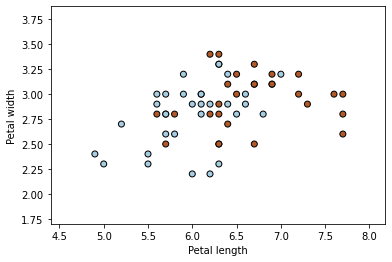

In [40]:
X = iris.data[:, :2]  # we only take the last two features.
Y = iris.target

h = .02  # step size in the mesh

X_train, X_test, y_train, y_test = train_test_split(X[Y!=0], np.where(Y[Y!=0]==2,1.0,-1.0), test_size=0.4, random_state=1) 
  
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - .5, X_train[:, 0].max() + .5
y_min, y_max = X_train[:, 1].min() - .5, X_train[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Petal length')
plt.ylabel('Petal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.show()

## SVM lineal para clasificación: svm.LinearSVC

Primero usaremos una SVM para clasificación con un kernel lineal. Esta está implementada en ``svm.LinearSVC`` (la _C_ al final es por *Classifier*).

El hiperparametro mas relevante es $C$.

In [41]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

-0.9999999991765415 9.300000026914072


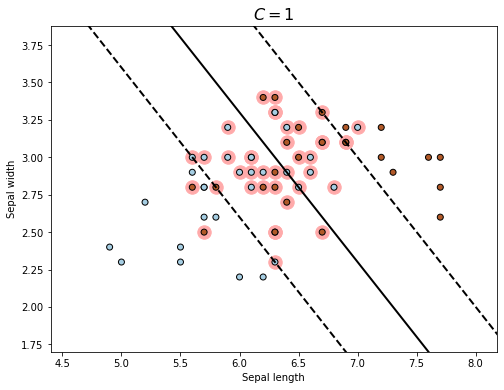

In [50]:
linear_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.LinearSVC(C=1, loss="hinge", random_state=42))
    ])

linear_svm_clf.fit(X_train, y_train)

Z = linear_svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 6))
#plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

b = linear_svm_clf.named_steps['svm_clf'].decision_function([-linear_svm_clf.named_steps['scaler'].mean_ / linear_svm_clf.named_steps['scaler'].scale_])
w = linear_svm_clf.named_steps['svm_clf'].coef_[0] / linear_svm_clf.named_steps['scaler'].scale_
linear_svm_clf.named_steps['svm_clf'].intercept_ = np.array([b])
#svm_clf2.intercept_ = np.array([b2])
linear_svm_clf.named_steps['svm_clf'].coef_ = np.array([w])
#svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y_train
support_vectors_idx = (t * (X_train.dot(w) + b) < 1).ravel()
linear_svm_clf.named_steps['svm_clf'].support_vectors_ = X_train[support_vectors_idx]

decision_boundary = -w[0]/w[1] * np.linspace(x_min,x_max,100) - b/w[1]
print(-w[0]/w[1],-b[0]/w[1])
margin = 1/w[1]
gutter_up = decision_boundary + margin
gutter_down = decision_boundary - margin

svs = X_train[support_vectors_idx]
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
plt.plot(np.linspace(x_min,x_max,100), decision_boundary, "k-", linewidth=2)
plt.plot(np.linspace(x_min,x_max,100), gutter_up, "k--", linewidth=2)
plt.plot(np.linspace(x_min,x_max,100), gutter_down, "k--", linewidth=2)


# Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.title("$C = {}$".format(linear_svm_clf.named_steps['svm_clf'].C), fontsize=16)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.show()


Podemos cambiar las funciones de base desde el Pipeline, tal como haciamos antes.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


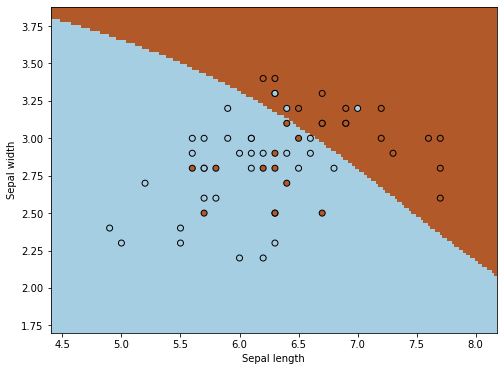

In [51]:
polynomial_svm_clf = Pipeline([
        ("poly_features", pp.PolynomialFeatures(degree=10)),
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.LinearSVC(C=1, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X_train, y_train)

Z = polynomial_svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)


# Plot also the training points
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.show()

## SVM no lineal para clasificación: svm.SVC

Una de las ventajas de las SVM es que solo dependen de los features $\phi$ a travez de su producto interno $K({\bf a},{\bf b}) = \phi({\bf a})^T \phi({\bf b})$. Esto define al _kernel_, y nos permite utilizar features mucho mas complejos, de dimensiones mucho mas grandes, sin tener que calcularlos explicitamente, mientras podamos calcular el kernel. Esta es la versión más general de las SVM para clasificación y el secreto de su poder. Estan implementados en la clase ``svm.SVC``, veamos algunos casos particulares.

Uno puede definir sus propios Kernels (incluso como simples funciones de python), pero los que vienen definidos por defecto en Scikit-Learn son los siguientes:

* ``linear``: $K({\bf a},{\bf b}) = {\bf a}^T {\bf b}$. 
Este es una SVM lineal, y se recomienda usar LinearSVC ya que es mucho más rápido y eficiente.
* ``poly``: $K({\bf a},{\bf b}) = \left(\gamma {\bf a}^T {\bf b} + r\right)^d$. 
Este es un kernel polinomial, y a diferencia de usar un kernel lineal con PolynomialFeatures, no requiere calcular la matriz de diseño lo cual es optimo para grados altos.
* ``rbf``: $K({\bf a},{\bf b}) = \exp\left(-\gamma||{\bf a}- {\bf b}||^2\right)$
Este es un kernel gaussiano, y correspondería a tomar un features $\phi$ de dimensión infinita (continua). Por suerte, su kernel se escribe de forma sencilla y es muy flexible.
* ``sigmoid``: $K({\bf a},{\bf b}) = \tanh\left(\gamma{\bf a}^T {\bf b} + r\right)$

Los cuales se pueden elegir con el argumento ``kernel=``, mientras que para sus parametros:
* $d $ se especifica en el argumento ``degree``
* $\gamma\ge 0$ se especifica en el argumento ``gamma``
* $r$ se especifica en el argumento ``coef0``

Todos los kernels poseen el hiperparametro $C$ que controla la flexibilidad del algoritmo.

### Kernel: Lineal

$K({\bf a},{\bf b}) = {\bf a}^T {\bf b}$

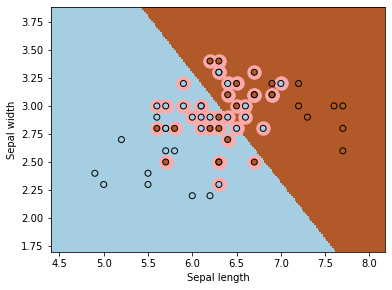

In [ ]:
linear_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='linear', C=10, random_state=42))
    ])

linear_svm_clf.fit(X_train, y_train)

Z = linear_svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4.5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
svs = linear_svm_clf[:-1].inverse_transform(linear_svm_clf.steps[-1][1].support_vectors_)
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)



plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

plt.show()

### Kernel: Polinomial

$K({\bf a},{\bf b}) = \left(\gamma {\bf a}^T {\bf b} + r\right)^d$
* $d $ se especifica en el argumento ``degree``
* $\gamma\ge 0$ se especifica en el argumento ``gamma``
* $r$ se especifica en el argumento ``coef0``

(1.7000000000000002, 3.880000000000002)

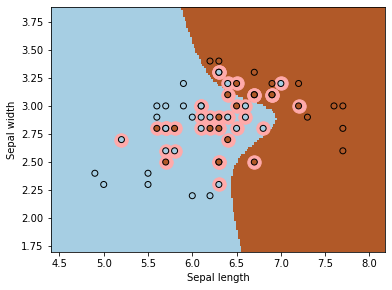

In [ ]:
polynomial_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='poly', degree=3, coef0=1, C=10, random_state=42))
    ])

polynomial_svm_clf.fit(X_train, y_train)

Z = polynomial_svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4.5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
svs = polynomial_svm_clf[:-1].inverse_transform(polynomial_svm_clf.steps[-1][1].support_vectors_)
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)



plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

En realidad, uno tiene que optimizar los hiperparametros. Para eso, y como antes, podemos usar GridSearchCV.

In [68]:
from sklearn.model_selection import GridSearchCV

polynomial_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='poly' ))
    ])

param_distributions = {"svm_clf__degree": np.arange(1, 10),"svm_clf__C": np.arange(1, 10),"svm_clf__coef0": np.linspace(0,2,5)}
grid_search_cv = GridSearchCV(polynomial_svm_clf, param_distributions, cv=3)
grid_search_cv.fit(X_train, y_train);

Veamos los mejores parametros

In [69]:
print(grid_search_cv.best_params_)

{'svm_clf__C': 6, 'svm_clf__coef0': 0.0, 'svm_clf__degree': 3}


Y grafiquemos el resultado:

(1.7000000000000002, 3.880000000000002)

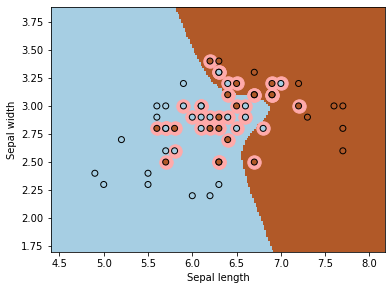

In [70]:
best_poly=grid_search_cv.best_estimator_
Z = best_poly.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4.5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
svs = best_poly[:-1].inverse_transform(best_poly.steps[-1][1].support_vectors_)
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)



plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

### Kernel: Gaussiano

$K({\bf a},{\bf b}) = \exp\left(-\gamma||{\bf a}- {\bf b}||^2\right)$
* $\gamma\ge 0$ se especifica en el argumento ``gamma``

(1.7000000000000002, 3.880000000000002)

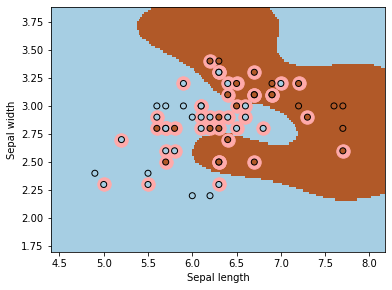

In [ ]:
gaussian_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='rbf', gamma=0.8, C=10, random_state=42))
    ])

gaussian_svm_clf.fit(X_train, y_train)

Z = gaussian_svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4.5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
svs = gaussian_svm_clf[:-1].inverse_transform(gaussian_svm_clf.steps[-1][1].support_vectors_)
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)



plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

En realidad, uno tiene que optimizar los hiperparametros. Para eso, y dado que los parametros pueden tomar muchos valores, conviene usar RandomizedSearchCV

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

gaussian_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='rbf'))
    ])
param_distributions = {"svm_clf__gamma": reciprocal(0.001, 0.1), "svm_clf__C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(gaussian_svm_clf, param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] svm_clf__C=4.745401188473625, svm_clf__gamma=0.07969454818643928 
[CV]  svm_clf__C=4.745401188473625, svm_clf__gamma=0.07969454818643928, total=   0.0s
[CV] svm_clf__C=4.745401188473625, svm_clf__gamma=0.07969454818643928 
[CV]  svm_clf__C=4.745401188473625, svm_clf__gamma=0.07969454818643928, total=   0.0s
[CV] svm_clf__C=4.745401188473625, svm_clf__gamma=0.07969454818643928 
[CV]  svm_clf__C=4.745401188473625, svm_clf__gamma=0.07969454818643928, total=   0.0s
[CV] svm_clf__C=8.31993941811405, svm_clf__gamma=0.015751320499779724 
[CV]  svm_clf__C=8.31993941811405, svm_clf__gamma=0.015751320499779724, total=   0.0s
[CV] svm_clf__C=8.31993941811405, svm_clf__gamma=0.015751320499779724 
[CV]  svm_clf__C=8.31993941811405, svm_clf__gamma=0.015751320499779724, total=   0.0s
[CV] svm_clf__C=8.31993941811405, svm_clf__gamma=0.015751320499779724 
[CV]  svm_clf__C=8.31993941811405, svm_clf__gamma=0.015751320499779724, total=   0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished


Veamos los befores parametros

In [55]:
rnd_search_cv.best_params_

{'svm_clf__C': 8.31993941811405, 'svm_clf__gamma': 0.015751320499779724}

Y ahora grafiquemos el mejor:

(1.7000000000000002, 3.880000000000002)

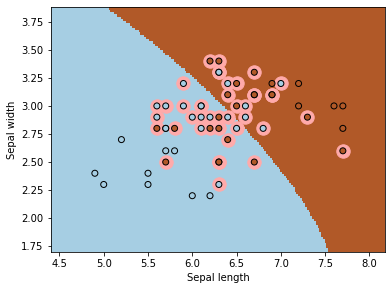

In [56]:
best_rbf=rnd_search_cv.best_estimator_
Z = best_rbf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4.5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
svs = best_rbf[:-1].inverse_transform(best_rbf.steps[-1][1].support_vectors_)
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)



plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

Como vemos, es muy equivalente al kernel polinomial.

### Kernel: Sigmoide

$K({\bf a},{\bf b}) = \exp\left(-\gamma||{\bf a}- {\bf b}||^2\right)$
* $\gamma\ge 0$ se especifica en el argumento ``gamma``
* $r$ se especifica en el argumento ``coef0``

(1.7000000000000002, 3.880000000000002)

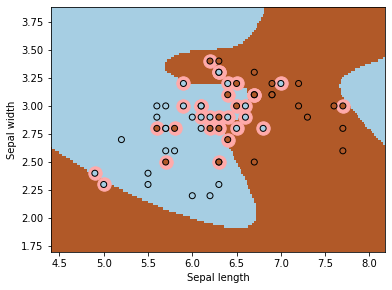

In [ ]:
sigmoid_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='sigmoid', gamma=0.7, coef0=-2, C=10, random_state=42))
    ])

sigmoid_svm_clf.fit(X_train, y_train)

Z = sigmoid_svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4.5))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
svs = sigmoid_svm_clf[:-1].inverse_transform(sigmoid_svm_clf.steps[-1][1].support_vectors_)
plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k', cmap=plt.cm.Paired)



plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
#plt.xticks(())
#plt.yticks(())

Como ejercicio, pueden hacer la optimizacion de parametros para este kernel.

# SVM: Clasificación Make_Moons

## Utilidades de ploteo:

Será util definir una función para plotear lindos los datos. Así como otra para plotear las predicciones de un modelo de scikit-learn (es decir la frontera de descición y pintar las regiones con colorcitos)

In [ ]:
#Este es el rango de X e Y que se ve bien para nuestro dataset
DEFAULT_AXIS=[-1.5, 2.5, -1, 1.5]

def plot_dataset(X, y, axes=DEFAULT_AXIS):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

def plot_predictions(clf, axes=DEFAULT_AXIS, plot_sv=False, plot_cont=True):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    if plot_cont:
        plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)
    if plot_sv:
        try:
            svs = clf[:-1].inverse_transform(clf.steps[-1][1].support_vectors_)
            plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
        except:
            print("LinearSVC no guarda los Support Vectors, para eso us SVC con kernel='linear'")

## Importamos / Generamos los Datos

Vamos a generar datos que no son linealmente separables usando la función make_moons de scikit-learn

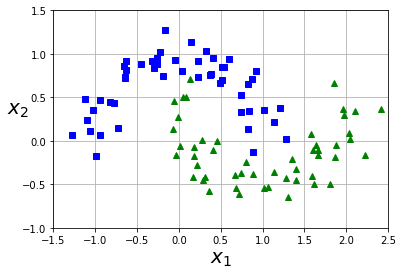

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
plot_dataset(X, y)
plt.show()

## SVM no lineal para clasificación: svm.SVC

### Kernel: Lineal

$K({\bf a},{\bf b}) = {\bf a}^T {\bf b}$

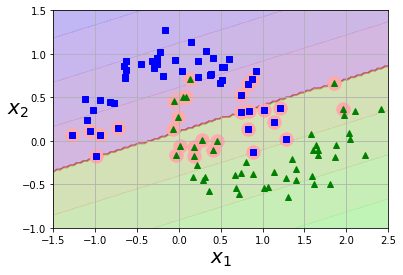

In [ ]:
linear_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='linear', C=10, random_state=42))
    ])

linear_svm_clf.fit(X, y)

plot_predictions(linear_svm_clf,plot_sv=True)
plot_dataset(X,y)
plt.show()

### Kernel: Polinomial

$K({\bf a},{\bf b}) = \left(\gamma {\bf a}^T {\bf b} + r\right)^d$
* $d $ se especifica en el argumento ``degree``
* $\gamma\ge 0$ se especifica en el argumento ``gamma``
* $r$ se especifica en el argumento ``coef0``

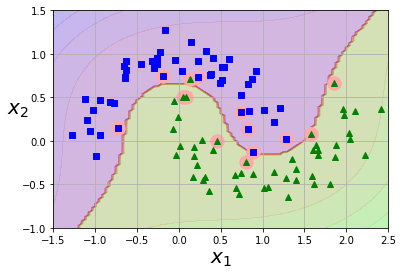

In [ ]:
polynomial_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='poly', degree=3, coef0=1, C=10, random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

plot_predictions(polynomial_svm_clf, plot_sv=True)
plot_dataset(X,y)
plt.show()

### Kernel: Gaussiano

$K({\bf a},{\bf b}) = \exp\left(-\gamma||{\bf a}- {\bf b}||^2\right)$
* $\gamma\ge 0$ se especifica en el argumento ``gamma``

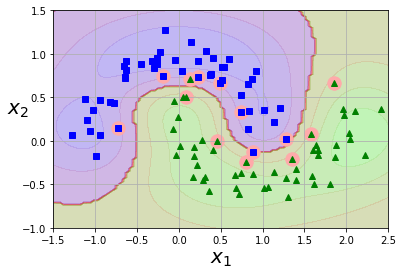

In [ ]:
gaussian_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='rbf', gamma=0.8, C=10, random_state=42))
    ])

gaussian_svm_clf.fit(X, y)

plot_predictions(gaussian_svm_clf, plot_sv=True)
plot_dataset(X,y)
plt.show()

### Kernel: Sigmoide

$K({\bf a},{\bf b}) = \exp\left(-\gamma||{\bf a}- {\bf b}||^2\right)$
* $\gamma\ge 0$ se especifica en el argumento ``gamma``
* $r$ se especifica en el argumento ``coef0``

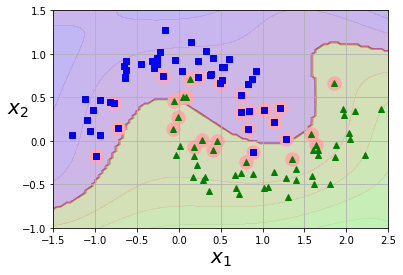

In [ ]:
sigmoid_svm_clf = Pipeline([
        ("scaler", pp.StandardScaler()),
        ("svm_clf", svm.SVC(kernel='sigmoid', gamma=0.7, coef0=-2, C=10, random_state=42))
    ])

sigmoid_svm_clf.fit(X, y)

plot_predictions(sigmoid_svm_clf, plot_sv=True)
plot_dataset(X,y)
plt.show()

# SVM: Regresión

El equivalente a las clases ``LinearSVC`` y ``SVC`` para regresión son las clases ``LinearSVR`` y ``SVR``, con idénticos parámetros y kernels.

Recordemos que el Clasificador intenta maximizar el margen entre clases, admitiendo o no excepciones segun el valor de ``C``. En el caso de Regresión, intenta meter todas los puntos dentro de un margen que nosotros especificamos con ``epsilon``, y admite excepciones segun el valor de ``C``.. Este  ``epsilon`` es un parámetro nuevo que el clasificador no tiene.

## Utilidades de Ploteo

In [60]:
DEFAULT_AXES=[-1, 1, 0, 1]

def plot_svm_regression(svm_reg, X, y, axes=DEFAULT_AXES):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

## Importamos / Generamos los datos

Como caso sencillo, hagamos una cuadratica con un poco de ruido (una normal de ancho $\sigma=0.1$). Samplearemos 100 puntos.

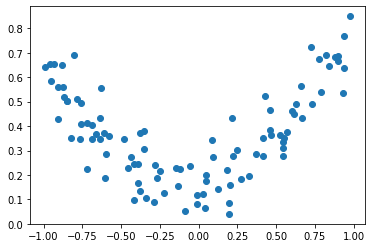

In [58]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

plt.scatter(X,y)
plt.show()

## Fiteamos con SVR

Abajo utilizaremos un kernel polinomial de grado 2. Como sabemos que el ancho del ruido es $\sigma=0.1$, fijemosnos que pasa colocando un ``epsilon=0.1``. El valor de C=100 indica cuantas excepciones permitimos.

Veamos que pasa al variar ``epsilon``.

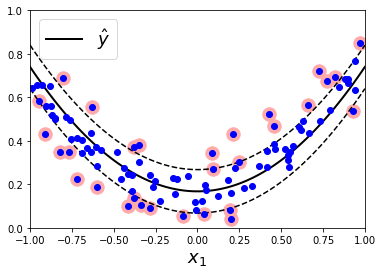

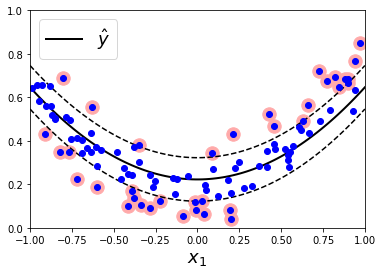

In [61]:
#C=100, epsilon=0.1
svm_poly_reg = svm.SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)
plot_svm_regression(svm_poly_reg, X, y)
plt.show()

#C=100, epsilon=0.05
svm_poly_reg = svm.SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)
plot_svm_regression(svm_poly_reg, X, y)
plt.show()